In [19]:
from datascience import *

import sympy
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
plt.style.use('seaborn-muted')
mpl.rcParams['figure.dpi'] = 200
%matplotlib inline

from IPython.display import display
import numpy as np
import pandas as pd
solve = lambda x,y: sympy.solve(x-y)[0] if len(sympy.solve(x-y))==1 else "Not Single Solution"

import warnings
warnings.filterwarnings('ignore')

# Market Equilibria

We will now explore the relationship between price and quantity of oranges produced between 1924 and 1938. Since the data {cite}`01demand-fruits` is from the 1920s and 1930s, it is important to remember that the prices are much lower than what they would be today because of inflation, competition, innovations, and other factors. For example, in 1924, a ton of oranges would have costed \$6.63; that same amount in 2019 is \$100.78. 

In [3]:
fruitprice = Table.read_table('fruitprice.csv')
fruitprice

Year,Pear Price,Pear Unloads (Tons),Plum Price,Plum Unloads,Peach Price,Peach Unloads,Orange Price,Orange Unloads,NY Factory Wages
1924,8.04,18489,8.86,6582,4.96,41880,6.63,21258,27.22
1925,5.67,21919,7.27,5526,4.87,38772,9.19,15426,28.03
1926,5.44,29328,6.68,5742,3.35,46516,7.2,24762,28.89
1927,7.15,17082,8.09,5758,5.7,32500,8.63,22766,29.14
1928,5.81,20708,7.41,6000,4.13,46820,10.71,18766,29.34
1929,7.6,13071,10.86,3504,6.7,36990,6.36,35702,29.97
1930,5.06,22068,6.23,7998,6.35,29680,10.5,23718,28.68
1931,5.4,19255,6.86,5638,3.91,50940,5.81,39263,26.35
1932,4.06,17293,6.09,7364,4.57,27642,4.71,38553,21.98
1933,4.78,11063,5.86,8136,3.57,35560,4.6,36540,22.26


## Finding the Equilibrium

An important concept in econmics is the market equilibrium. This is the point at which the demand and supply curves meet and represents the "optimal" level of production and price in that market.

```{admonition} Definition
The **market equilibrium** ...
```

Let's walk through how to the market equilibrium using the market for oranges as an example.

### Data Preprocessing

Because we are only examining the relationship between prices and quantity for oranges, we can create a new table with the relevant columns: `Year`, `Orange Price`, and `Orange Unloads`. 

In [7]:
oranges_raw = fruitprice.select("Year", "Orange Price", "Orange Unloads")
oranges_raw

Year,Orange Price,Orange Unloads
1924,6.63,21258
1925,9.19,15426
1926,7.2,24762
1927,8.63,22766
1928,10.71,18766
1929,6.36,35702
1930,10.5,23718
1931,5.81,39263
1932,4.71,38553
1933,4.6,36540


Next, we will rename our columns. In this case, let's rename `Orange Unloads` to `Quantity` and `Orange Price` to `Price` for brevity and understandability. 

In [8]:
oranges = oranges_raw.relabel("Orange Unloads", "Quantity").relabel("Orange Price", "Price")
oranges

Year,Price,Quantity
1924,6.63,21258
1925,9.19,15426
1926,7.2,24762
1927,8.63,22766
1928,10.71,18766
1929,6.36,35702
1930,10.5,23718
1931,5.81,39263
1932,4.71,38553
1933,4.6,36540


### Visualize the  Relationship

To construct the demand curve, let's first see what the relationship between price and quantity is. We would expect to see a downward-sloping line between price and quantity; if a product's price increases, consumers will purchase less, and if a product's price decreases, then consumers will purchase more. 

To find this, we will create a scatterplot and draw a regression line (by setting `fit_line = True` in the `oranges.scatter` scall) between the points. Regression lines are helpful because they consolidate all the datapoints into a single line, helping us better understand the relationship between the two variables. 

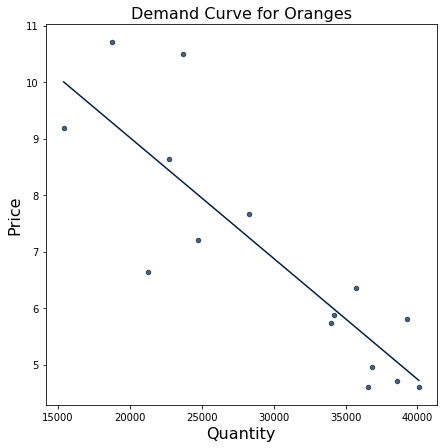

In [21]:
oranges.scatter("Quantity", "Price", fit_line = True, width=7, height=7)
plt.title("Demand Curve for Oranges", fontsize = 16);

The visualization shows a negative relationship between quantity and price, which is exactly what we expected! As we've discussed, as the price increases, fewer consumers will purchase the oranges, so the quantity demanded will decrease. This corresponds to a leftward movement along the demand curve. Alternatively, as the price decreases, the quantity sold will increase because consumers want to maximize their purchasing power and buy more oranges; this is shown by a rightward movement along the curve.


As a quick refresher, scatterplots can show positive, negative, or neutral correlations among two variables: 
- If two variables have a positive correlation, then as one variable increases, the other increases too. 
- If two variables have a negative correlation, then as one variable increass, the other decreases. 
- If two variables have a neutral correlation, then if one varible increases, the other variable stays constant. 

Note that scatterplots do not show or prove causation between two variables-- it is up to the data scientists to prove any causation. 

### Fit a Polynomial

We will now quantify our demand curve using NumPy's [`np.polyfit` functio](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html). `np.polyfit` returns an array of size 2, where the first element is the slope and the second is the $y$-intercept.

It takes 3 parameters:
- array of x-coordinates
- array of y-coordinates
- degree of polynomial 

Because we are looking for a **linear** function to serve as the demand curve, we will use 1 for the degree of polynomial. 

The general template for the demand curve is $y = mx + b$, where $m$ is the slope and $b$ is $y$-intercept. In economic terms, $m$ is the demand curve's slope that shows how the good's price affects the quantity demanded, and $b$ encompasses the effects of all of the exogenous non-price factors that affect demand. 

In [22]:
np.polyfit(oranges.column("Quantity"), oranges.column("Price"), 1)

array([-2.14089690e-04,  1.33040264e+01])

This shows that the demand curve is $y = -0.000214x+ 13.3$. The slope is -0.000214 and $y$-intercept is 13.3. That means that as quantity increases by 1 unit (in this case, 1 ton), price decreases by 0.000214 units (in this case, \$0.000214). 

### Create the Demand Curve

We will now use SymPy to write out this demand curve. To do so, we start by creating a symbol `Q` that we can use to create the equation.

In [24]:
Q = sympy.Symbol("Q")
demand = -0.000214 * Q + 13.3
demand

-0.000214*Q + 13.3

### Create the Supply Curve

As we will learn, the supply curve is the relationship between the price of a good or service and the quantity of that good or service that the seller is willing to supply. They show how much of a good suppliers are willing and able to supply at different prices. In this case, as the price of the beef increases, the quantity of beef that beef manufacturers are willing to supply increases. They capture the producer's side of market decisions and are upward-sloping.

Let's now assume that the supply curve is given by $P = 0.00023Q + 0.8$. (Note that this supply curve is not based on data.)

In [25]:
supply = 0.00023 * Q + 0.8
supply

0.00023*Q + 0.8

 This means that as the quantity of oranges produced increases by 1, the supply curve increases by 0.00023. It originally starts out with 0.8.

### Find the Quantity Equilibrium

With the supply and demand curves known, we can solve the for equilibrium. 
The equilibrium is the point where the supply curve and demand curve intersect, and denotes the price and quantity of the good transacted in the market.
At this point, the quantity of the good that consumers desire to purchase is equivalent to the quantity of the good that producers supply; there is no shortage or surplus of the good at this quantity. 
The equilbrium consists of 2 components: the quantity equilbrium and price equilbrium. 
The quantity equilibrium is the quantity at which the supply curve and demand curve intersect.

Let's find the quantity equilibrium for this exercise. To do this, we will use the provided `solve` function. This is a custom function that leverages some SymPy magic and will be provided to you in assignments.

In [27]:
Q_star = solve(demand, supply)
Q_star

28153.1531531532

This means that the number of tons of oranges that consumers want to purchase and producers want to provide in this market is about 28,153 tons of oranges. 

### Find the Price Equilibrium

Similarly, the price equilibrium is the price at which the supply curve and demand curve intersect. The price of the good that consumers desire to purchase at is equivalent to the price of the good that producers want to sell at. There is no shortage of surplus of the product at this price.

Let's find the price equilibrium. 

In [28]:
demand.subs(Q, Q_star)
supply.subs(Q, Q_star)

7.27522522522523

This means that the price of oranges in tons that consumers want to purchase at and producers want to provide is about \$7.27. 

### Visualize the Market Equilibrium 

Now that we have our demand and supply curves and price and quantity equilibria, we can visualize them on a graph to see what they look like. 

There are 2 pre-made functions we will use: `plot_equation` and `plot_intercept`.
- `plot_equation`: It takes in the equation we made previously (either demand or supply) and visualizes the equations between the different prices we give it
- `plot_intercept`: It takes in two different equations (demand and supply), finds the point at which the two intersect, and creates a scatter plot of the result

In [30]:
def plot_equation(equation, price_start, price_end, label=None):
    plot_prices = [price_start, price_end]
    plot_quantities = [equation.subs(list(equation.free_symbols)[0], c) for c in plot_prices]
    plt.plot(plot_prices, plot_quantities, label=label)
    
def plot_intercept(eq1, eq2):
    ex = sympy.solve(eq1-eq2)[0]
    why = eq1.subs(list(eq1.free_symbols)[0], ex)
    plt.scatter([ex], [why], zorder=10, color="tab:orange")
    return (ex, why)

We can leverage these functions and the equations we made earlier to create a graph that shows the market equilibrium.

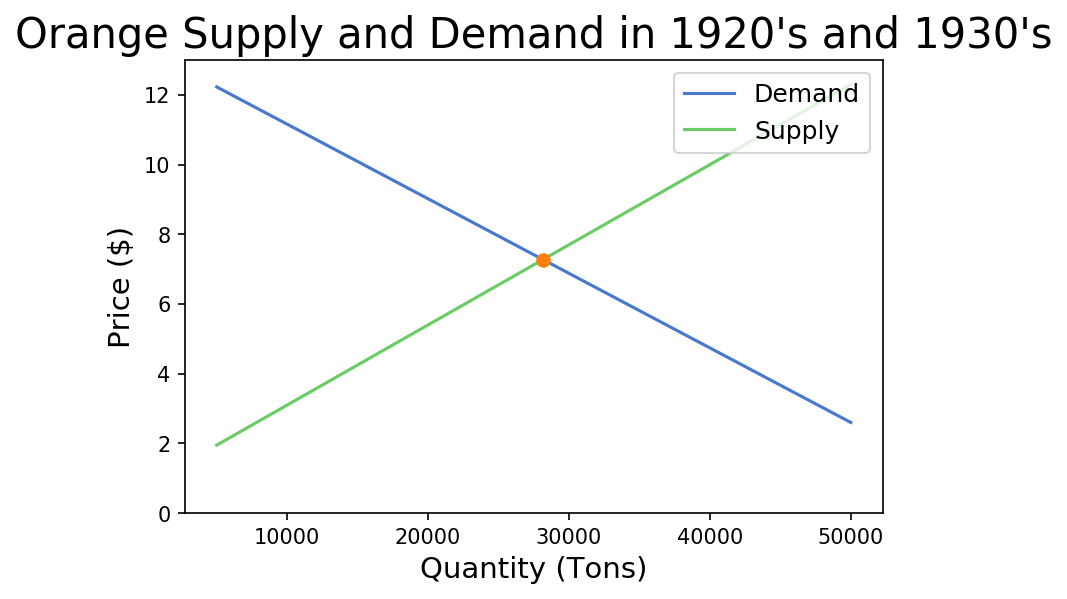

In [31]:
mpl.rcParams['figure.dpi'] = 150
plot_equation(demand, 5000, 50000, label = "Demand")
plot_equation(supply, 5000, 50000, label = "Supply")
plt.ylim(0,13)
plt.title("Orange Supply and Demand in 1920's and 1930's", fontsize = 20)
plt.xlabel("Quantity (Tons)", fontsize = 14)
plt.ylabel("Price ($)", fontsize = 14)
plot_intercept(supply, demand)
plt.legend(loc = "upper right", fontsize = 12)
plt.show()

You can also practice on your own and download additional data sets [here](http://users.stat.ufl.edu/~winner/datasets.html), courtesy of the University of Flordia's Statistics Department. 

## Movements Away from Equilibrium

What happens to market equilibrium when either supply or demand shifts due to an exogenous shock?

Let's assume that consumers now prefer Green Tea as their hot beverage of choice moreso than before. We have an outward shift of the demand curve - quantity demanded is greater at every price. The market is no longer in equilibrium.

```{figure} fig1-demand.png
---
width: 500px
name: demand-shift
---
A shift in the demand curve
```

![title](fig1-demand.png)

At the same price level (the former equilibrium price), there is a shortage of Green Tea. The amount demanded by consumers exceeds that supplied by producers: $Q_D > Q_S$. This is a seller's market, as the excess quantity demanded gives producers leverage (or market power) over consumers. They are able to increase the price of Green Tea to clear the shortage. As prices increase, consumers who were willing and able to purchase tea at the previous equilibrium price would leave the market, reducing quantity demanded. $Q_S$ and $Q_D$ move up along their respective curves until the new equilibrium is achieved where $Q_S = Q_D$. 

This dual effect of increasing $Q_S$ and $Q_D$ is sometimes referred to as the "invisible hand". Sans government intervention, it clears out the shortage or surplus in the market, resulting in the eventual convergence to a new equilibrium level of quantity $Q^*$ and price $P^*$.